In [35]:
# Do not modify
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from scipy.stats import zscore
# inline plotting instead of popping out
%matplotlib inline


df = pd.read_csv(
    'http://archive.ics.uci.edu/ml/machine-learning-databases/00381/PRSA_data_2010.1.1-2014.12.31.csv',
    sep=',')
df.head()


,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
0,1,2010,1,1,0,NaN,-21,-11.0,1021.0,NW,1.79,0,0
1,2,2010,1,1,1,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2,3,2010,1,1,2,NaN,-21,-11.0,1019.0,NW,6.71,0,0
3,4,2010,1,1,3,NaN,-21,-14.0,1019.0,NW,9.84,0,0
4,5,2010,1,1,4,NaN,-20,-12.0,1018.0,NW,12.97,0,0


In [36]:
# Do not modify
df = df.drop(['cbwd'], axis=1)  # drop non-scalar feature
df = df.dropna(axis=0, how='any')  # drop samples who has nan feature

#remove outlier
z_scores = zscore(df)
abs_z_scores = np.abs(z_scores)
df = df[(abs_z_scores < 3).all(axis=1)]
display(df)


,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,Iws,Is,Ir
24,25,2010,1,2,0,129.0,-16,-4.0,1020.0,1.79,0,0
25,26,2010,1,2,1,148.0,-15,-4.0,1020.0,2.68,0,0
26,27,2010,1,2,2,159.0,-11,-5.0,1021.0,3.57,0,0
27,28,2010,1,2,3,181.0,-7,-5.0,1022.0,5.36,1,0
28,29,2010,1,2,4,138.0,-7,-5.0,1022.0,6.25,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...
43807,43808,2014,12,31,7,8.0,-22,-5.0,1034.0,143.03,0,0
43808,43809,2014,12,31,8,8.0,-22,-5.0,1034.0,150.18,0,0
43809,43810,2014,12,31,9,8.0,-22,-3.0,1034.0,155.99,0,0
43810,43811,2014,12,31,10,7.0,-22,-2.0,1034.0,163.14,0,0


In [37]:
# Do not modify
idx = np.logical_or(
    np.logical_and(df['year'].values == 2014, df['month'].values < 3),
    np.logical_and(df['year'].values == 2013, df['month'].values == 12))
X = df.loc[idx].drop('pm2.5', axis=1)
y = df.loc[idx]['pm2.5'].values

print(X.shape)
print(y.shape)

(1925, 11)
(1925,)


Index(['No', 'year', 'month', 'day', 'hour', 'DEWP', 'TEMP', 'PRES', 'Iws',
       'Is', 'Ir'],
      dtype='object')


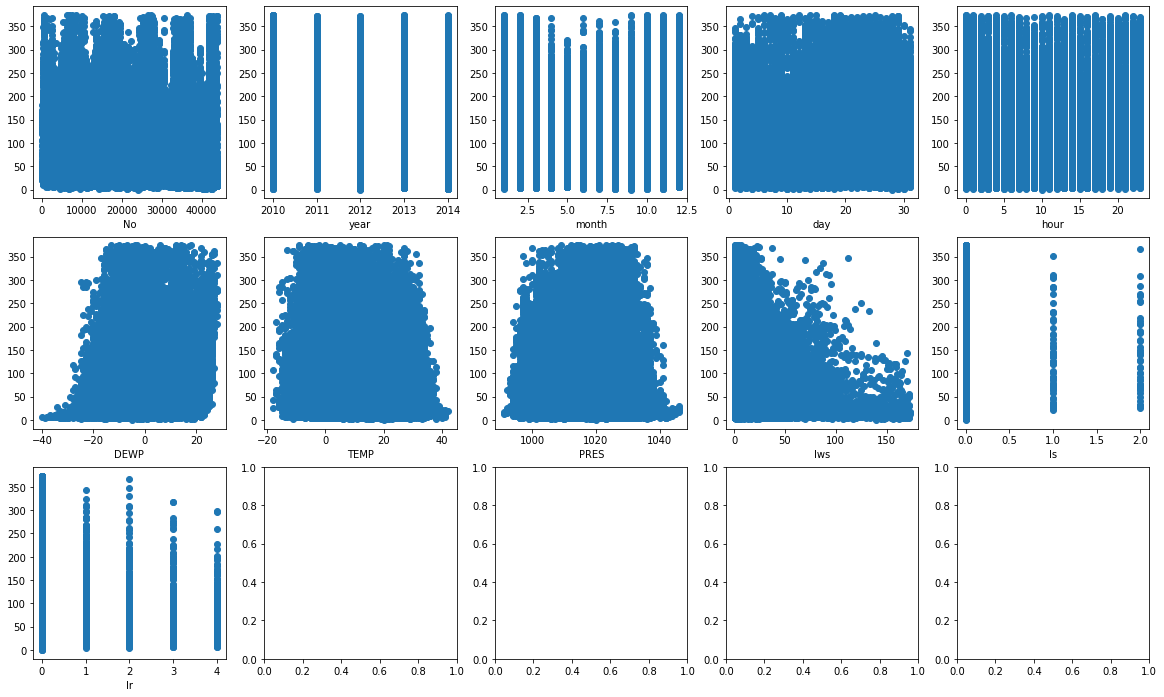

In [38]:
labels = X.columns
print(labels)

_, subplot_arr = plt.subplots(3, 5, figsize=(20, 12))
for idx, label in enumerate(labels):
  x_idx = idx // 5
  y_idx = idx % 5
  subplot_arr[x_idx, y_idx].scatter(df[label], df['pm2.5'])
  subplot_arr[x_idx, y_idx].set_xlabel(label)

plt.show()


In [39]:
#Linear Regression
class LinearRegressionGD(object):
  def __init__(self, eta=0.001, n_iter=20, random_state=1):
    self.eta = eta
    self.n_iter = n_iter
    self.random_state = random_state
  
  def fit(self, X, y):
    rgen = np.random.RandomState(self.random_state)
    self.w_ = rgen.normal(loc=0.0, scale=0.01, size=1 + X.shape[1])
    self.cost_ = []

    for i in range(self.n_iter):
      output = self.net_input(X)

      #Cost
      error = (y - output)
      cost = (error**2).sum() / 2.0
      self.cost_.append(cost)

      #Update Rule
      self.w_[1:] += self.eta * X.T.dot(error)
      self.w_[0] += self.eta * error.sum()
    
    return self

  def net_input(self, X):
    return np.dot(X, self.w_[1:]) + self.w_[0]

  def predict(self, X):
    return self.net_input(X)

**Linear(Polynomial) Regressor Model**

In [44]:
#Split data
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Standardization
poly = PolynomialFeatures(degree=5)
X_train_quad = poly.fit_transform(x_train)
X_test_quad = poly.fit_transform(x_test)

#Training Linear Regressor
linearRG = LinearRegression()
linearRG.fit(X_train_quad, y_train)

#Testing
y_train_pred = linearRG.predict(X_train_quad)
y_test_pred = linearRG.predict(X_test_quad)

print('MSE train: %.2f, test: %.2f' %
      (mean_squared_error(y_train, y_train_pred),
       mean_squared_error(y_test, y_test_pred)))
print('R^2 train: %.2f, test: %.2f' % (r2_score(y_train, y_train_pred),
                                       r2_score(y_test, y_test_pred)))


MSE train: 1268.15, test: 2759.03
R^2 train: 0.87, test: 0.72


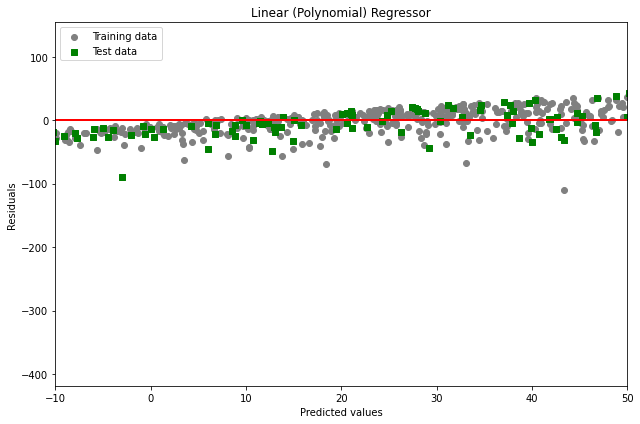

In [45]:
#Residual Plot
plt.figure(figsize=(9,6))
plt.scatter(
    y_train_pred, y_train_pred - y_train, c='grey', marker='o', label='Training data')
plt.scatter(
    y_test_pred, y_test_pred - y_test, c='green', marker='s', label='Test data')

plt.title('Linear (Polynomial) Regressor')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc='upper left')
plt.hlines(y=0, xmin=-10, xmax=50, lw=2, color='red')
plt.xlim([-10, 50])
plt.tight_layout()
plt.show()


**Random Forest Regressor Model**

In [46]:
#Random Forest Regressor
#Split data
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

#Standardization
sc = StandardScaler()
x_train_std = sc.fit_transform(x_train)
x_test_std = sc.fit_transform(x_test)

forest = RandomForestRegressor(n_estimators=1000, criterion='mse', random_state=1, n_jobs=-1)
forest.fit(x_train_std, y_train)

y_train_pred = forest.predict(x_train_std)
y_test_pred = forest.predict(x_test_std)

print('MSE train: %.2f, test: %.2f' %
      (mean_squared_error(y_train, y_train_pred),
       mean_squared_error(y_test, y_test_pred)))
print('R^2 train: %.2f, test: %.2f' % (r2_score(y_train, y_train_pred),
                                       r2_score(y_test, y_test_pred)))

MSE train: 155.88, test: 1569.14
R^2 train: 0.98, test: 0.84


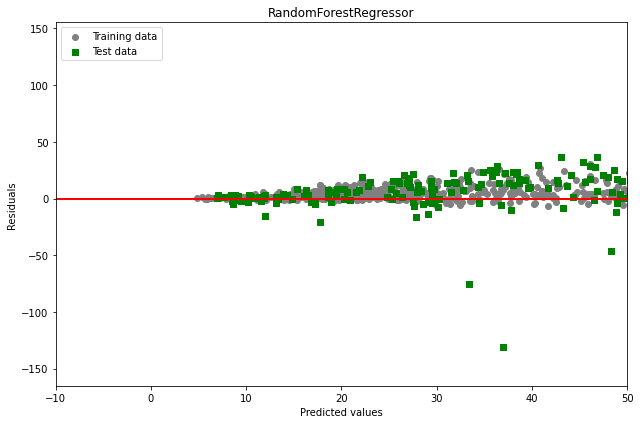

In [47]:
#Residual Plot
plt.figure(figsize=(9,6))
plt.scatter(
    y_train_pred, y_train_pred - y_train, c='gray', marker='o', label='Training data')
plt.scatter(
    y_test_pred, y_test_pred - y_test, c='green', marker='s', label='Test data')

plt.title('RandomForestRegressor')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc='upper left')
plt.hlines(y=0, xmin=-10, xmax=50, lw=2, color='red')
plt.xlim([-10, 50])
plt.tight_layout()
plt.show()
